# **download the data**

In [1]:
!wget -O mini_speech_commands.zip https://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip
!unzip -q mini_speech_commands.zip -d mini_speech_commands

--2025-03-01 21:20:42--  https://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.189.207, 173.194.194.207, 172.217.214.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.189.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182082353 (174M) [application/zip]
Saving to: ‘mini_speech_commands.zip’

mini_speech_command 100%[===================>] 173.65M   190MB/s    in 0.9s    

2025-03-01 21:20:43 (190 MB/s) - ‘mini_speech_commands.zip’ saved [182082353/182082353]



# imports

In [2]:
import os
import librosa
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import librosa.util
from scipy.fftpack import dct

# access the audio file

In [3]:

down_dir = "/content/mini_speech_commands/mini_speech_commands/down"

audio_files = sorted(os.listdir(down_dir))

wav_file = os.path.join(down_dir, audio_files[0])

print("First audio file path:", wav_file)

ipd.Audio(wav_file)

First audio file path: /content/mini_speech_commands/mini_speech_commands/down/004ae714_nohash_0.wav


# load the wav file

Audio Length: 16000 samples
Sample Rate: 16000 Hz


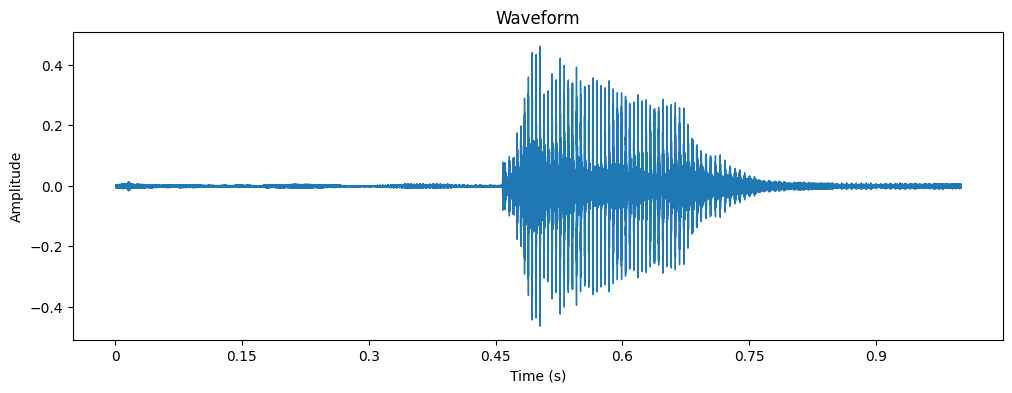

In [4]:

wav_file_sampled, sr = librosa.load(wav_file, sr=None)

print(f"Audio Length: {len(wav_file_sampled)} samples")
print(f"Sample Rate: {sr} Hz")

plt.figure(figsize=(12, 4))
librosa.display.waveshow(wav_file_sampled, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()






# the spectrum of the speech

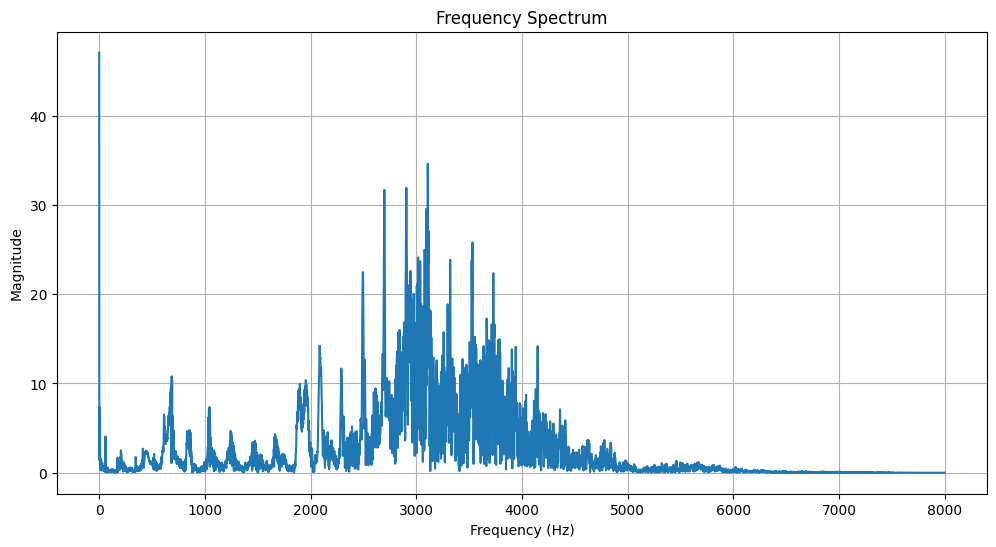

In [5]:
# Compute FFT
fft_result = np.fft.fft(wav_file_sampled)  # Apply FFT
magnitude = np.abs(fft_result)  # Get magnitude spectrum
frequency = np.fft.fftfreq(len(magnitude), d=1/sr)  # Get frequency axis

# Keep only the positive half of frequencies (FFT is symmetric)
half_length = len(frequency) // 2
frequency = frequency[:half_length]
magnitude = magnitude[:half_length]

# Plot frequency domain
plt.figure(figsize=(12, 6))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum")
plt.grid()
plt.show()

# apply the prepreemphasize


In [6]:
alpha = 0.95
wav_file_preemphasized = np.append(wav_file_sampled[0], wav_file_sampled[1:] - alpha * wav_file_sampled[:-1])  # Filter formula



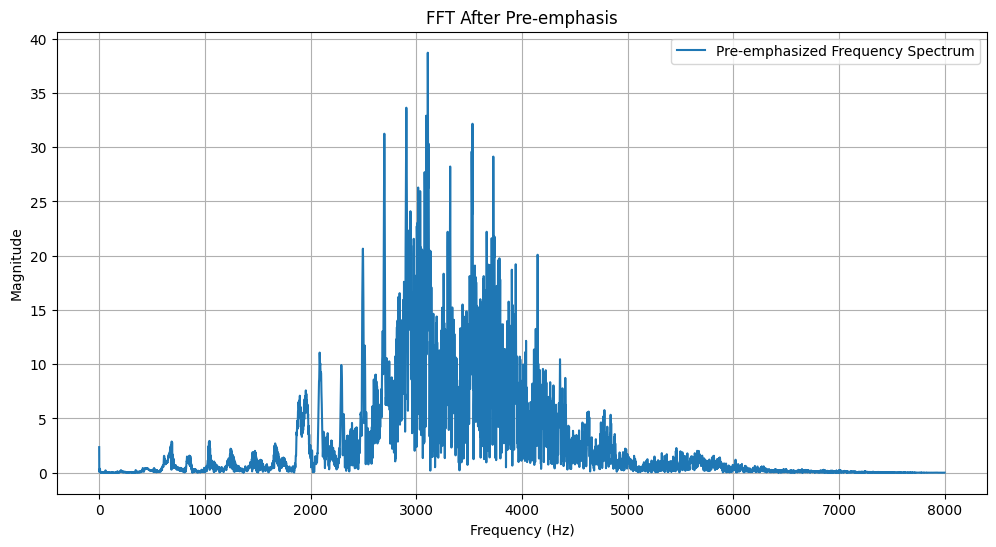

In [7]:
# Compute FFT after pre-emphasis
fft_result = np.fft.fft(wav_file_preemphasized)
magnitude = np.abs(fft_result)
frequency = np.fft.fftfreq(len(magnitude), d=1/sr)



# Keep only the positive half of the spectrum
half_length = len(frequency) // 2
frequency = frequency[:half_length]
magnitude = magnitude[:half_length]

# Plot frequency response after pre-emphasis
plt.figure(figsize=(12, 6))
plt.plot(frequency, magnitude, label="Pre-emphasized Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT After Pre-emphasis")
plt.grid()
plt.legend()
plt.show()


# calculate short time fourier transform with hanning window


In [8]:
frame_size = int(sr * 0.025)  # 25 ms frame default
hop_length = int(sr * 0.01)   # 10 ms hop (stride) default
def compute_stft(x, frame_size, hop_length):

    frame_count = 1 + (len(x) - frame_size) // hop_length


    stft = np.zeros((frame_count, 1 + frame_size // 2), dtype=complex)


    for k in range(frame_count):
        x_frame = x[k * hop_length:k * hop_length + frame_size]
        x_frame = x_frame * np.hanning(len(x_frame))

        stft[k, :] = np.fft.rfft(x_frame)

    return stft.T

In [9]:
stft_mag = np.abs(compute_stft(wav_file_preemphasized, frame_size, hop_length))
print(stft_mag.shape)

(201, 98)


the number of frequency bins is 400 / 2 + 1 = 201
as the fft is symmetric. the number of frames is 1 + floor((16000 - 400) /160 ) = 98

# plot the spectrogram

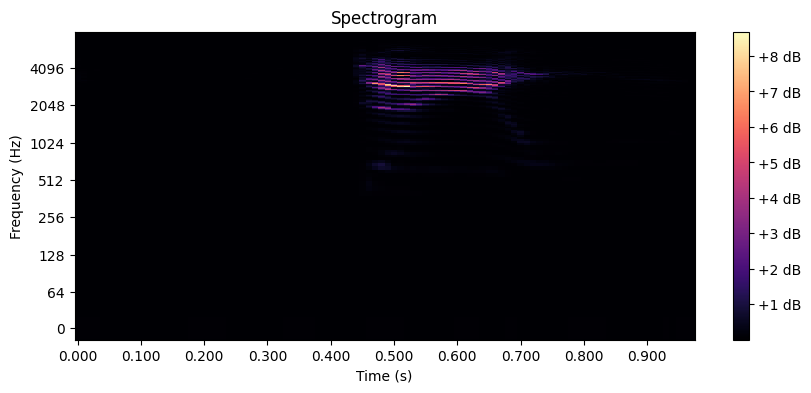

In [10]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(stft_mag,
                         sr=sr, hop_length=hop_length,
                         y_axis='log', x_axis='time')

plt.colorbar(format='%+2.0f dB')  # Add color bar
plt.title("Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


#  calculate the filter banks


In [11]:
def mel_to_freq(mel_freq):
    return 700 * (10 ** (mel_freq / 2595) - 1)


def freq_to_mel(freq):
  return 2595 * np.log10(1 + freq / 700)

In [12]:
low_freq = 300

high_freq = sr // 2

mel_low_freq = freq_to_mel(low_freq)

mel_high_freq = freq_to_mel(high_freq)

num_points = 80 + 2

mel_points = np.linspace(mel_low_freq, mel_high_freq, num_points)

hz_points = mel_to_freq(mel_points)

freq_to_bin = np.floor((frame_size + 1) * hz_points / sr)

filter_banks = np.zeros((num_points-2, frame_size // 2 + 1))

for j in range(1, num_points-1 ):

  left = int(freq_to_bin[j-1])

  center = int(freq_to_bin[j])

  right = int(freq_to_bin[j+1])


  for i in range(left, center):

      filter_banks[j - 1, i] = (i - left) / (center - left)

  for i in range(center, right):

        filter_banks[j - 1, i] = (right - i) / (right - center)
print(filter_banks.shape)


(80, 201)


# plot the filter banks

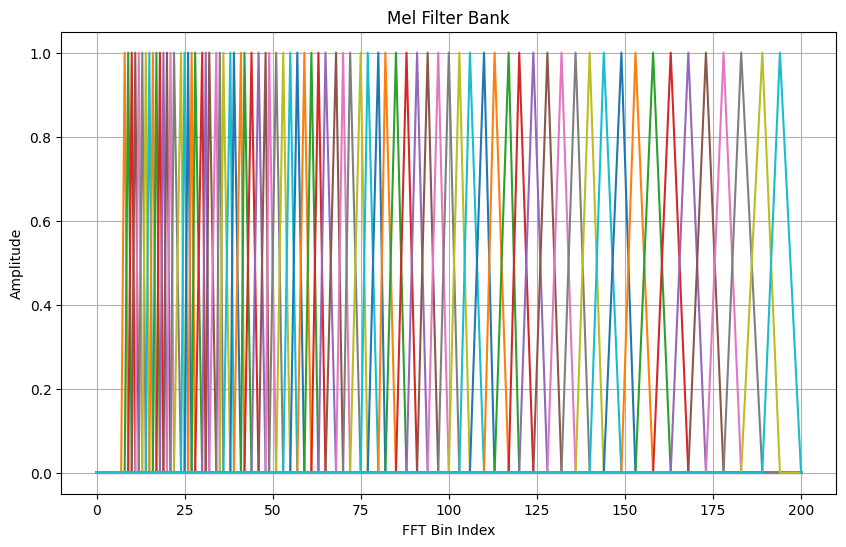

In [13]:
# Plot the filter banks
plt.figure(figsize=(10, 6))
for i in range(filter_banks.shape[0]):
    plt.plot(filter_banks[i], label=f'Filter {i+1}')

plt.title('Mel Filter Bank')
plt.xlabel('FFT Bin Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# generate the mel spectrogram and take the log


In [14]:
mel_spectrogram = np.dot(filter_banks, stft_mag)
log_mel_spectrogram = np.log(mel_spectrogram + 1e-10)
mel_spectrogram.shape


(80, 98)

# plot the log mel spctrogram


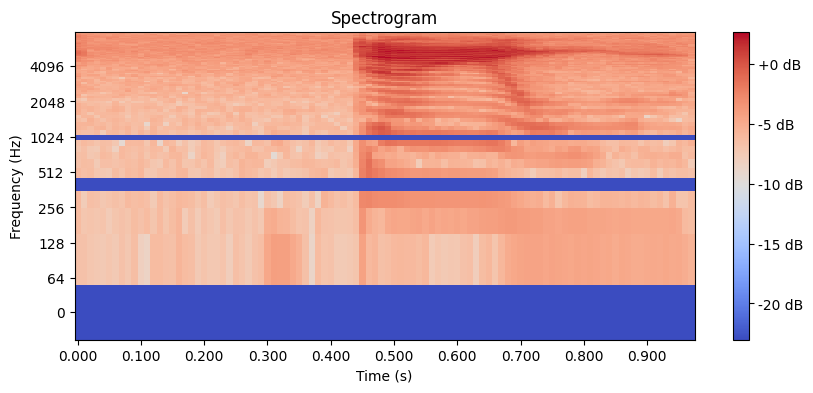

In [15]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram,
                         sr=sr, hop_length=hop_length,
                         y_axis='log', x_axis='time')

plt.colorbar(format='%+2.0f dB')  # Add color bar
plt.title("Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

# applying the discrete cosine fourier transform and take the first 12

In [16]:

def dct_ii(x):

    M, N = x.shape
    dct_out = np.zeros((M, N))

    for k in range(M):
        for n in range(M):
            dct_out[k, :] += x[n, :] * np.cos(np.pi * k * (2 * n + 1) / (2 * M))

        dct_out[k, :] *= np.sqrt(2 / M) if k > 0 else np.sqrt(1 / M)

    return dct_out


mfcc_features = dct_ii(log_mel_spectrogram)[:12, :]

print("MFCC shape:", mfcc_features.shape)


MFCC shape: (12, 98)



> Add blockquote



In [17]:
def compute_derivatives(mfccs):
    num_coeffs, num_frames = mfccs.shape
    mfccs_derivative = np.zeros((num_coeffs , num_frames))

    for i in range(num_coeffs):
      for j in range(num_frames):
        if j == 0:
          mfccs_derivative[i, j] = (mfccs[i, j+1] - mfccs[i, j])

        elif j == num_frames - 1:
          mfccs_derivative[i, j] = (mfccs[i, j] - mfccs[i, j-1])
        else:
          mfccs_derivative[i, j] = (mfccs[i, j+1] - mfccs[i, j-1]) / 2.0

    return mfccs_derivative



In [18]:
first_derivative = compute_derivatives(mfcc_features)
second_derivative = compute_derivatives(mfcc_features)
second_derivative.shape

(12, 98)

# add the power

In [19]:

def append_power_to_mfccs(mfccs):

    num_coeffs, num_frames = mfccs.shape
    mfccs_with_power = np.zeros((num_coeffs + 1, num_frames))

    mfccs_with_power[:num_coeffs, :] = mfccs

    mfccs_with_power[num_coeffs, :] = np.sum(mfccs**2, axis=0)

    return mfccs_with_power

mfccs_with_power = append_power_to_mfccs(mfcc_features)
print(mfccs_with_power.shape)




(13, 98)


#  the first and seconds derivatives


In [20]:
def compute_derivatives(mfccs):
    num_coeffs, num_frames = mfccs.shape
    mfccs_derivative = np.zeros((num_coeffs , num_frames))

    for i in range(num_coeffs):
      for j in range(num_frames):
        if j == 0:
          mfccs_derivative[i, j] = (mfccs[i, j+1] - mfccs[i, j])

        elif j == num_frames - 1:
          mfccs_derivative[i, j] = (mfccs[i, j] - mfccs[i, j-1])
        else:
          mfccs_derivative[i, j] = (mfccs[i, j+1] - mfccs[i, j-1]) / 2.0

    return mfccs_derivative



In [21]:
first_derivative = compute_derivatives(mfccs_with_power)
second_derivative = compute_derivatives(first_derivative)
print(first_derivative.shape)
print(second_derivative.shape)

(13, 98)
(13, 98)


In [22]:

mfccs_with_power.shape

(13, 98)

In [23]:
print(mfccs_with_power)


[[-4.17200599e+01 -4.47820798e+01 -4.69120700e+01 ... -4.22467545e+01
  -4.34171529e+01 -4.54902995e+01]
 [-2.03464644e+01 -2.03283363e+01 -1.80672391e+01 ... -1.58296689e+01
  -1.64230062e+01 -1.59645407e+01]
 [-1.16043097e+01 -1.05177990e+01 -1.00956051e+01 ... -1.10030598e+01
  -1.15572039e+01 -9.21045424e+00]
 ...
 [-1.18196751e+00 -1.55648418e+00 -6.68103541e-01 ... -1.69787233e+00
  -1.72270279e+00 -1.57317843e+00]
 [-3.58422503e-02  1.11695664e-01  6.16517356e-02 ... -1.58111316e+00
  -1.76782787e+00 -7.33507688e-01]
 [ 2.35950424e+03  2.60054121e+03  2.69862537e+03 ...  2.22572847e+03
   2.36476528e+03  2.49964807e+03]]


# concatenate the 3 matricies

In [24]:
final_mfcc = np.concatenate((mfccs_with_power, first_derivative, second_derivative), axis=0)

In [25]:
print(final_mfcc.shape)

(39, 98)


In [28]:
print(final_mfcc)

[[-4.17200599e+01 -4.47820798e+01 -4.69120700e+01 ... -4.22467545e+01
  -4.34171529e+01 -4.54902995e+01]
 [-2.03464644e+01 -2.03283363e+01 -1.80672391e+01 ... -1.58296689e+01
  -1.64230062e+01 -1.59645407e+01]
 [-1.16043097e+01 -1.05177990e+01 -1.00956051e+01 ... -1.10030598e+01
  -1.15572039e+01 -9.21045424e+00]
 ...
 [ 6.31448651e-01  2.11821940e-01 -2.17298769e-01 ...  2.49513832e-01
   3.24223726e-02  8.71774107e-02]
 [-9.87909215e-02 -9.10802103e-02  3.08708654e-02 ...  4.10720984e-01
   5.32846189e-01  6.10517445e-01]
 [-7.14764085e+01 -5.99957814e+01 -4.58474418e+01 ...  4.34027058e+01
   1.67211176e+01 -2.07701330e+00]]


## plot the mfcc

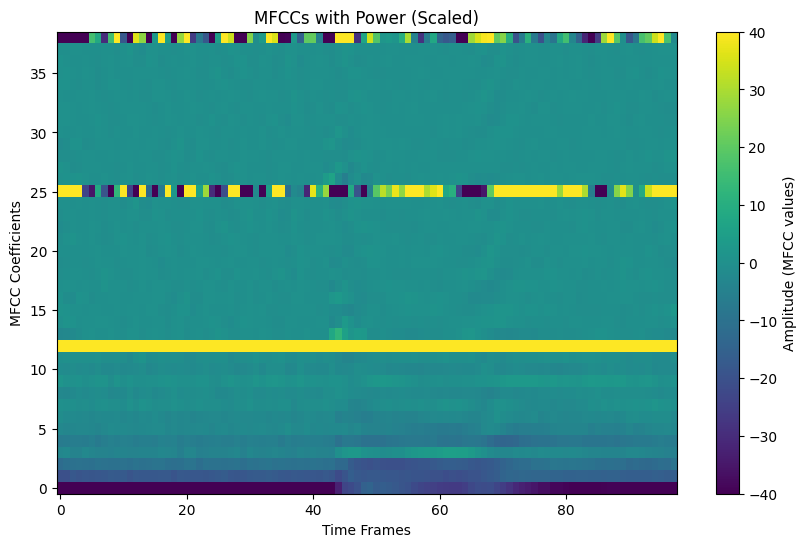

In [31]:
plt.figure(figsize=(10, 6))
plt.imshow(final_mfcc, aspect='auto', origin='lower', cmap='viridis', vmin=-40, vmax=40)
plt.colorbar(label="Amplitude (MFCC values)")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.title("MFCCs with Power (Scaled)")
plt.show()

the 13th row, 26th , 39th  are pretty high because they contain the enegry, delta energy and delta delta energy which have  a different scale than the rest values ,  i have done that according to the sildes and : An introduction to natural language processing,
 computational linguistics, and speech recognition. Daniel Jurafsky & James H. Martin book chapter 9 section 3 .

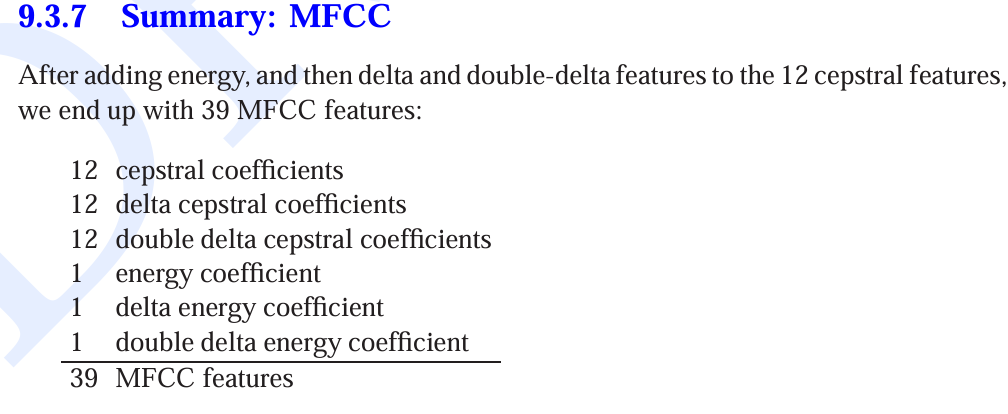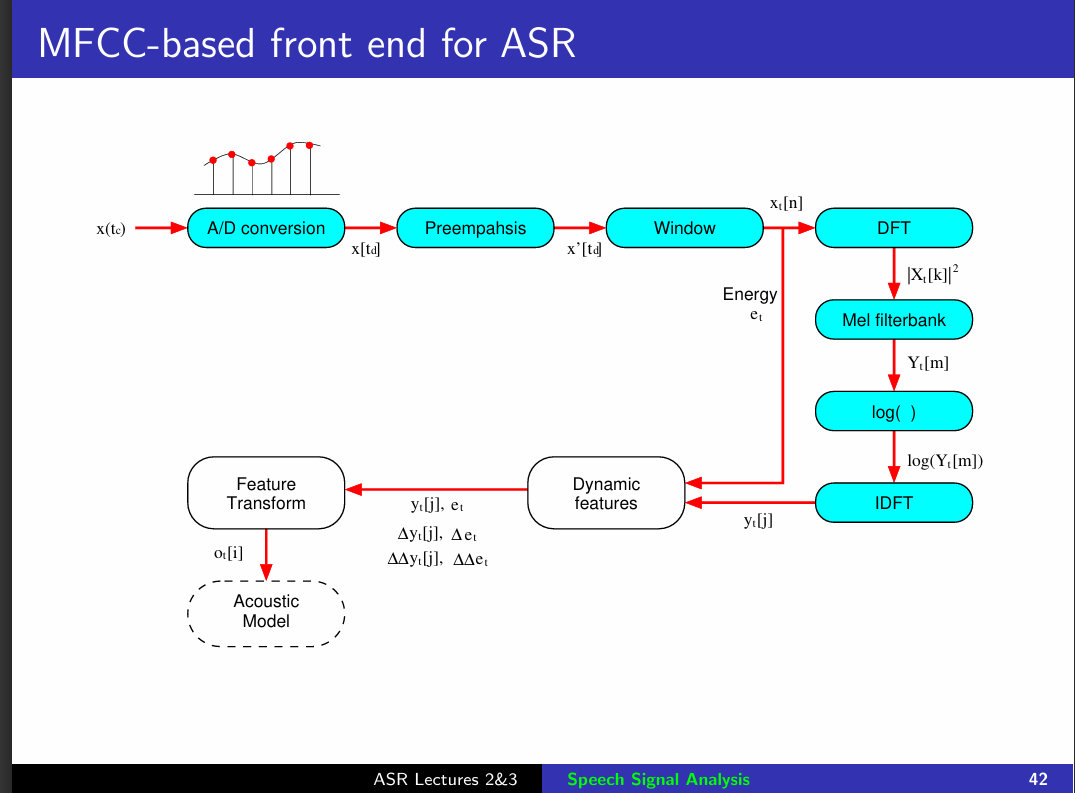